In [1]:
import numpy as np
import torch
from data.synthetic_dataset import * #create_synthetic_dataset, SyntheticDataset , ECG5000Dataset,load_ECG5000
from models.seq2seq import EncoderRNN, DecoderRNN, Net_GRU
from models.conv_lstm import *
from loss.dilate_loss import dilate_loss
from torch.utils.data import DataLoader
import random
from tslearn.metrics import dtw, dtw_path
import matplotlib.pyplot as plt
import warnings
import warnings; warnings.simplefilter('ignore')


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
random.seed(0)

# parameters
batch_size = 100
N_input = 84
N_output = 56 
sigma = 0.01
gamma = 0.01

# Load synthetic dataset
# X_train_input,X_train_target,X_test_input,X_test_target,train_bkp,test_bkp = create_synthetic_dataset(N,N_input,N_output,sigma)
# dataset_train = SyntheticDataset(X_train_input,X_train_target, train_bkp)
# dataset_test  = SyntheticDataset(X_test_input,X_test_target, test_bkp)
# trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
# testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)


# Load ECG dataset
filepath_train = '/cvlabdata2/cvlab/datasets_yiwang/ECG5000_TRAIN.txt'
filepath_test = '/cvlabdata2/cvlab/datasets_yiwang/ECG5000_TEST.txt'
x_train_ip, x_train_op, x_test_ip, x_test_op, train_bkp, test_bkp = load_ECG5000(filepath_train, filepath_test)
# print (x_train_ip.shape, x_train_op.shape, x_test_ip.shape, x_test_op.shape)
dataset_train = ECG5000Dataset(x_train_ip, x_train_op, train_bkp)
dataset_test  = ECG5000Dataset(x_test_ip, x_test_op, test_bkp)
trainloader = DataLoader(dataset_train, batch_size=batch_size,shuffle=True, num_workers=1)
testloader  = DataLoader(dataset_test, batch_size=batch_size,shuffle=False, num_workers=1)

def train_model(net,loss_type, learning_rate, epochs=1000, gamma = 0.001,
                print_every=50,eval_every=50, verbose=1, Lambda=1, alpha=0.5):
    
    optimizer = torch.optim.Adam(net.parameters(),lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs): 
        for i, data in enumerate(trainloader, 0):
            inputs, target, _ = data
            inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
            target = torch.tensor(target, dtype=torch.float32).to(device)
            batch_size, N_output = target.shape[0:2]                     

            # forward + backward + optimize
            outputs = net(inputs)
            loss_mse,loss_shape,loss_temporal = torch.tensor(0),torch.tensor(0),torch.tensor(0)
            
            if (loss_type=='mse'):
                loss_mse = criterion(target,outputs)
                loss = loss_mse                   
 
            if (loss_type=='dilate'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
            
            if (loss_type=='dilate_shape'):    
                loss, loss_shape, loss_temporal = dilate_loss(target,outputs,alpha, gamma, device)     
                loss = loss_shape
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()          
        
        if(verbose):
            if (epoch % print_every == 0):
                print('epoch ', epoch, ' loss ',loss.item(),' loss shape ',loss_shape.item(),' loss temporal ',loss_temporal.item())
                eval_model(net,testloader, gamma,verbose=1)
  

 
def eval_model(net,loader, gamma,verbose=1):   
    criterion = torch.nn.MSELoss()
    losses_mse = []
    losses_dtw = []
    losses_tdi = []   

    for i, data in enumerate(loader, 0):
        loss_mse, loss_dtw, loss_tdi = torch.tensor(0),torch.tensor(0),torch.tensor(0)
        # get the inputs
        inputs, target, breakpoints = data
        inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
        target = torch.tensor(target, dtype=torch.float32).to(device)
        batch_size, N_output = target.shape[0:2]
        outputs = net(inputs)
         
        # MSE    
        loss_mse = criterion(target,outputs)    
        loss_dtw, loss_tdi = 0,0
        # DTW and TDI
        for k in range(batch_size):         
            target_k_cpu = target[k,:,0:1].view(-1).detach().cpu().numpy()
            output_k_cpu = outputs[k,:,0:1].view(-1).detach().cpu().numpy()

            loss_dtw += dtw(target_k_cpu,output_k_cpu)
            path, sim = dtw_path(target_k_cpu, output_k_cpu)   
                       
            Dist = 0
            for i,j in path:
                    Dist += (i-j)*(i-j)
            loss_tdi += Dist / (N_output*N_output)            
                        
        loss_dtw = loss_dtw /batch_size
        loss_tdi = loss_tdi / batch_size

        # print statistics
        losses_mse.append( loss_mse.item() )
        losses_dtw.append( loss_dtw )
        losses_tdi.append( loss_tdi )

    print( ' Eval mse= ', np.array(losses_mse).mean() ,' dtw= ',np.array(losses_dtw).mean() ,' tdi= ', np.array(losses_tdi).mean()) 

    
net_cnn_lstm_dilate = Net_Cnn_Lstm(device, in_channels=1, out_channels=30, N_input=N_input, hidden_dim=128, batch_size=batch_size, num_layers=1, output_size=N_output).to(device)
train_model(net_cnn_lstm_dilate,loss_type='dilate',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

net_cnn_lstm_mse = Net_Cnn_Lstm(device, in_channels=1, out_channels=30, N_input=N_input, hidden_dim=128, batch_size=batch_size, num_layers=1, output_size=N_output).to(device)
train_model(net_cnn_lstm_mse,loss_type='mse',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)

net_cnn_lstm_dialte_shape = Net_Cnn_Lstm(device, in_channels=1, out_channels=30, N_input=N_input, hidden_dim=128, batch_size=batch_size, num_layers=1, output_size=N_output).to(device)
train_model(net_cnn_lstm_dialte_shape,loss_type='dilate_shape',learning_rate=0.001, epochs=1000, gamma=gamma, print_every=50, eval_every=50,verbose=1)




epoch  0  loss  16.908222198486328  loss shape  28.392953872680664  loss temporal  5.423492431640625
 Eval mse=  1.130573108461168  dtw=  4.40358399137871  tdi=  5.553116992630386
epoch  50  loss  4.001573085784912  loss shape  6.527212142944336  loss temporal  1.4759342670440674
 Eval mse=  0.547319714890586  dtw=  2.487129810485016  tdi=  1.7586806264172339
epoch  100  loss  1.285757064819336  loss shape  1.7693145275115967  loss temporal  0.8021995425224304
 Eval mse=  0.38230098353491887  dtw=  1.6701450614669533  tdi=  1.062501275510204
epoch  150  loss  0.9084173440933228  loss shape  1.288981318473816  loss temporal  0.5278533101081848
 Eval mse=  0.342618575029903  dtw=  1.6216711240387733  tdi=  0.919968253968254
epoch  200  loss  0.7915968894958496  loss shape  1.0425128936767578  loss temporal  0.5406808257102966
 Eval mse=  0.3218804389238358  dtw=  1.6080634443622217  tdi=  0.8215533588435374
epoch  250  loss  0.7067606449127197  loss shape  0.8093611598014832  loss tempor

 Eval mse=  0.8455916417969598  dtw=  1.71907334330703  tdi=  2.9990856717687078
epoch  400  loss  0.6607607007026672  loss shape  0.6607607007026672  loss temporal  2.8450350761413574
 Eval mse=  0.8379019723998176  dtw=  1.7186245947880423  tdi=  3.010946782879819
epoch  450  loss  0.6073232889175415  loss shape  0.6073232889175415  loss temporal  2.261604070663452
 Eval mse=  0.8358051604694791  dtw=  1.7353177665830926  tdi=  2.9352954223356007
epoch  500  loss  0.6572405695915222  loss shape  0.6572405695915222  loss temporal  2.435556173324585
 Eval mse=  0.8501953125  dtw=  1.7390040020802966  tdi=  3.0201038123582773
epoch  550  loss  0.4467904567718506  loss shape  0.4467904567718506  loss temporal  2.453737735748291
 Eval mse=  0.8375203265084161  dtw=  1.7409777264034523  tdi=  3.00314951814059
epoch  600  loss  0.5301970839500427  loss shape  0.5301970839500427  loss temporal  2.427461624145508
 Eval mse=  0.8329457759857177  dtw=  1.7474643938150396  tdi=  2.99779209183673

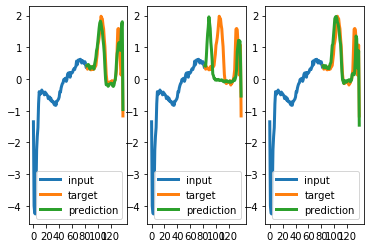

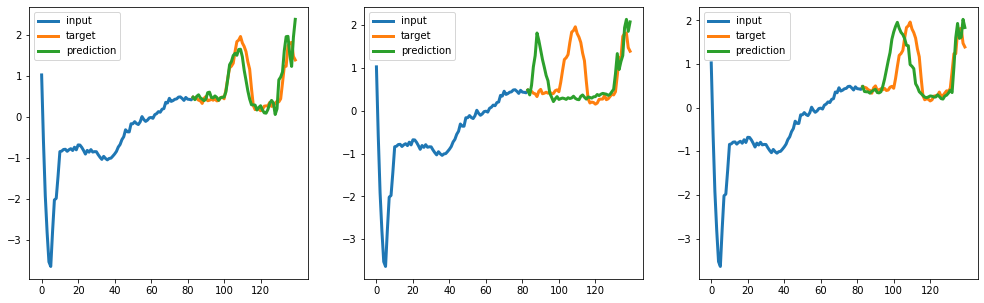

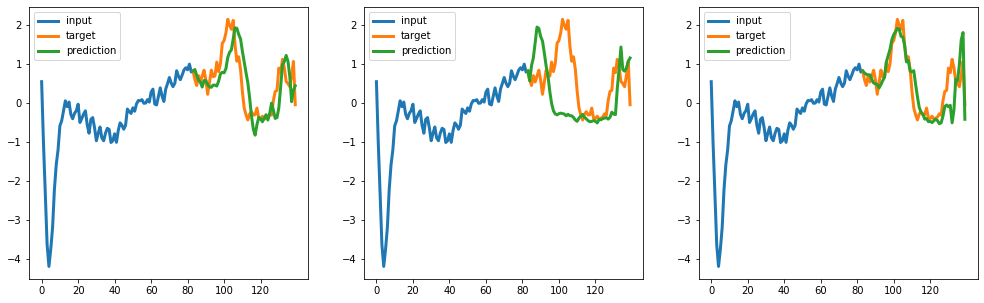

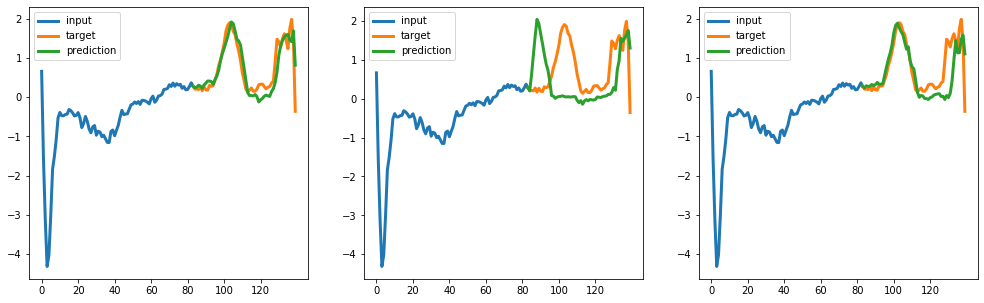

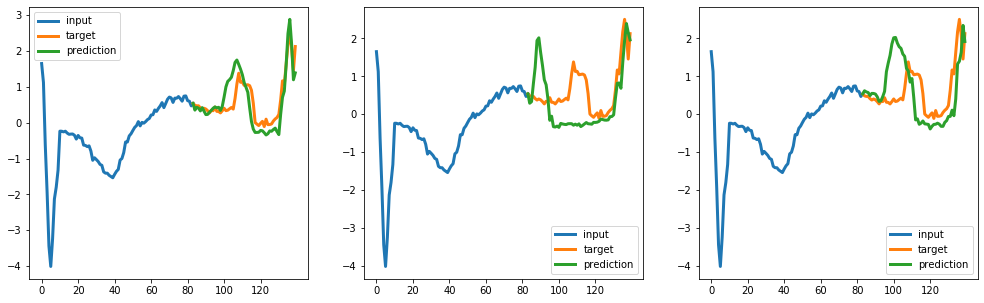

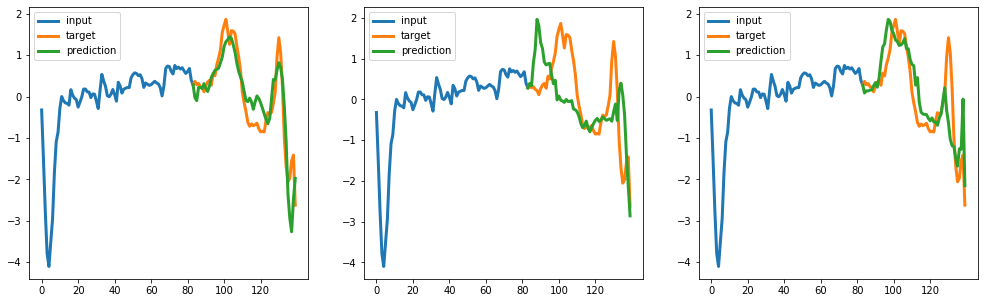

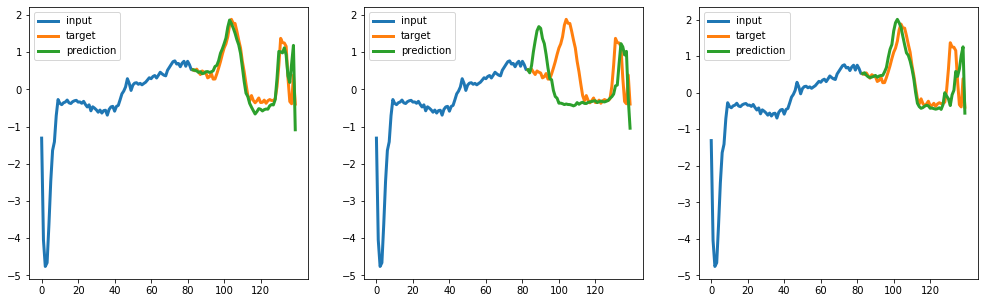

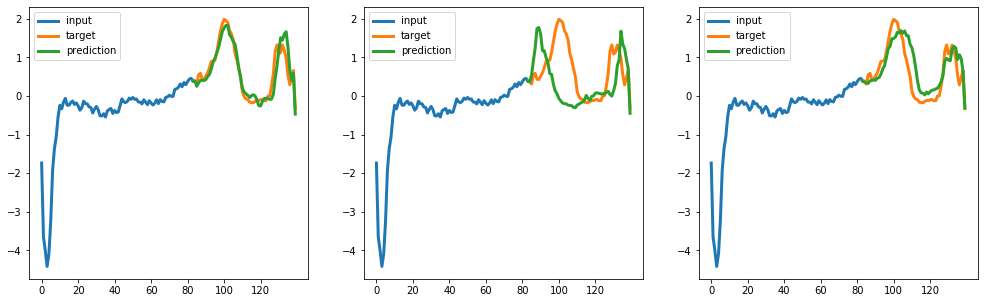

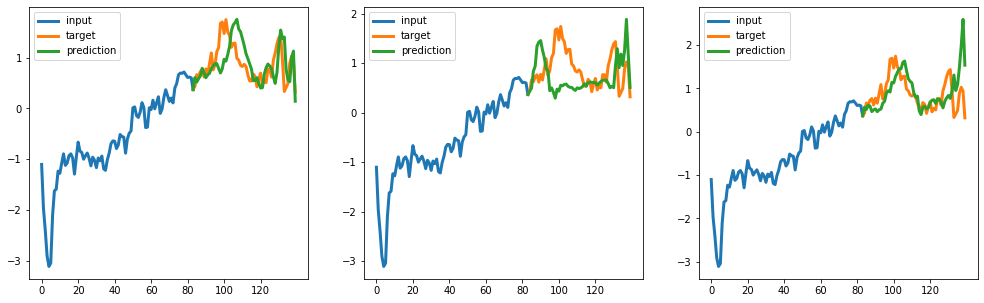

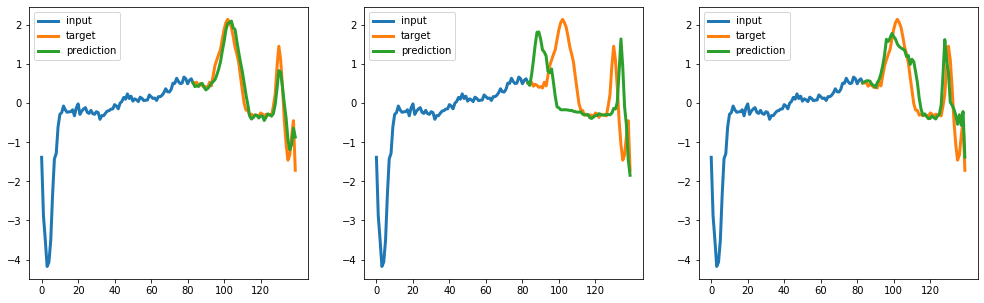

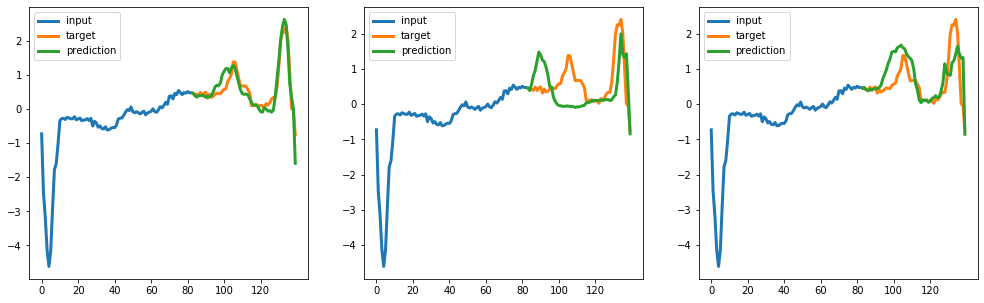

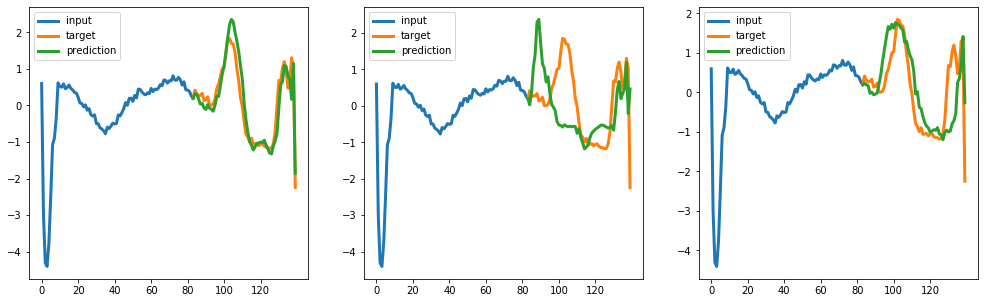

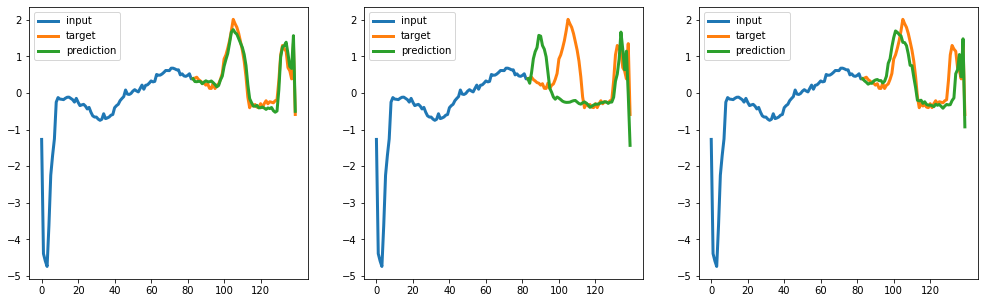

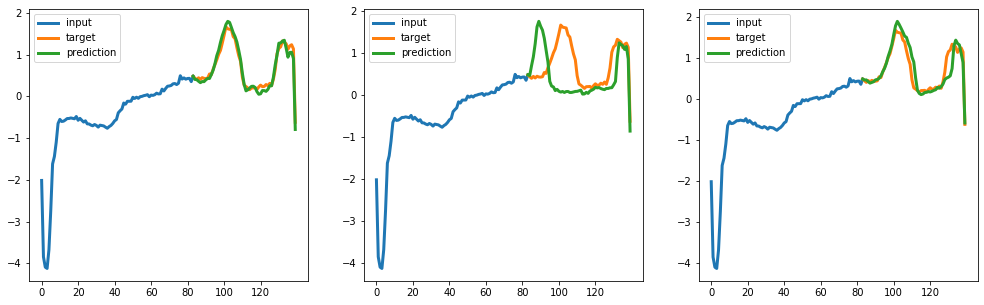

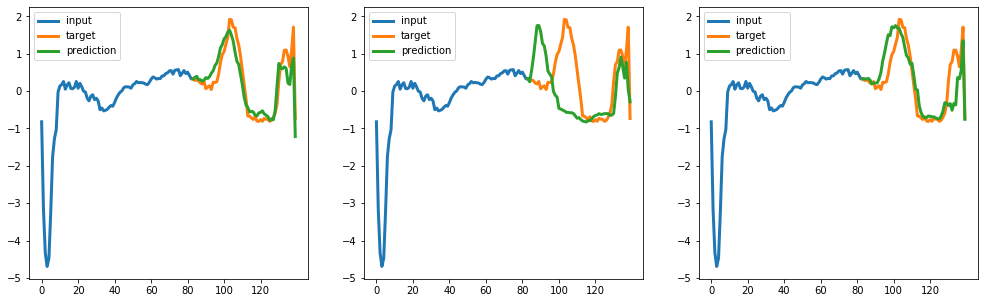

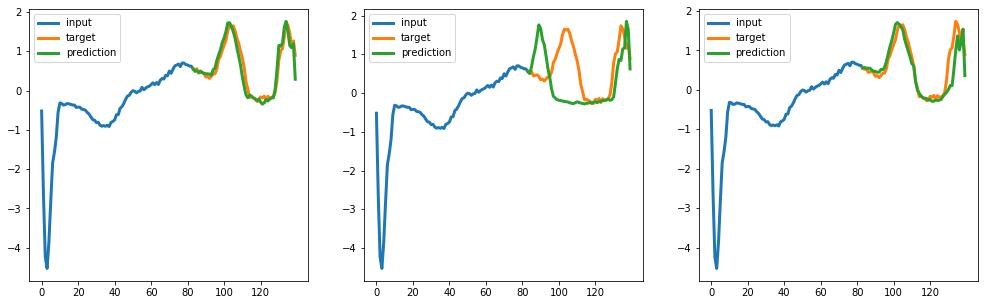

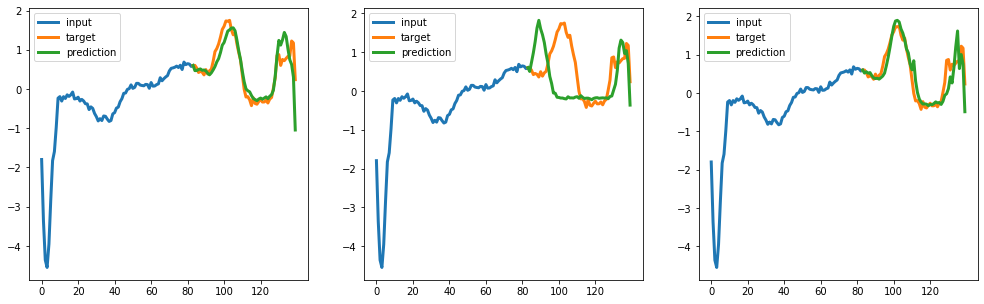

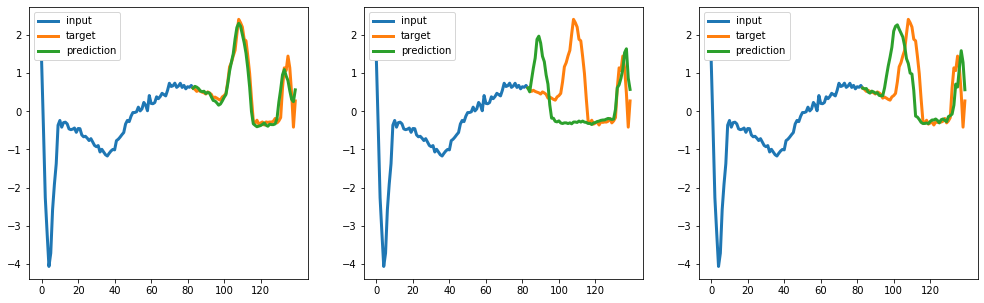

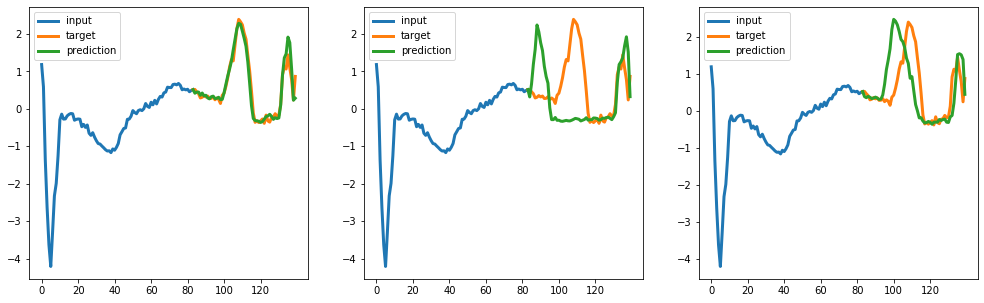

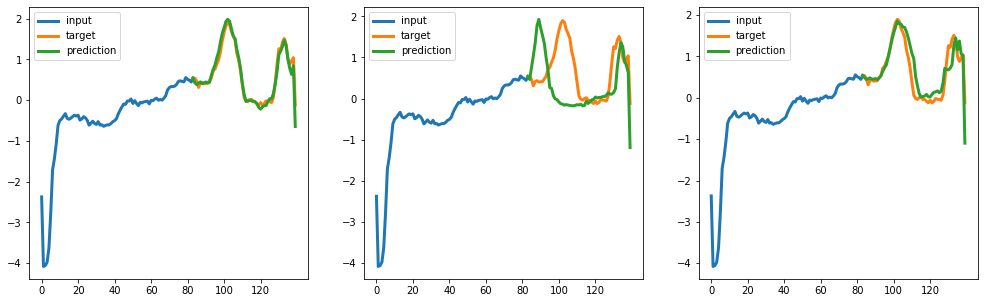

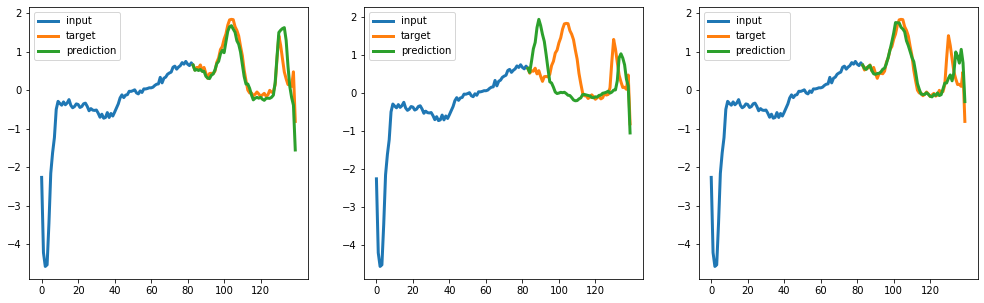

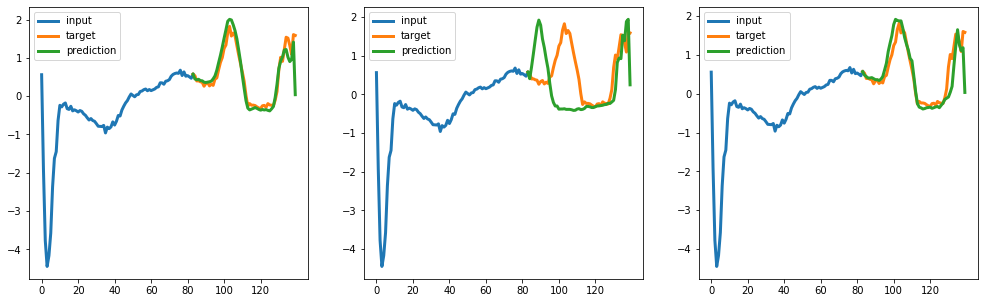

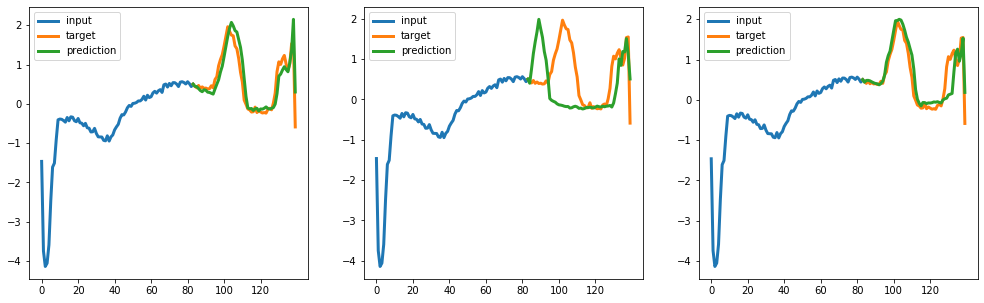

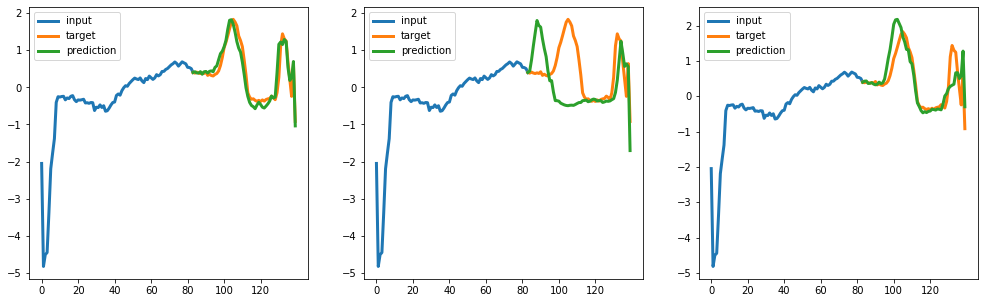

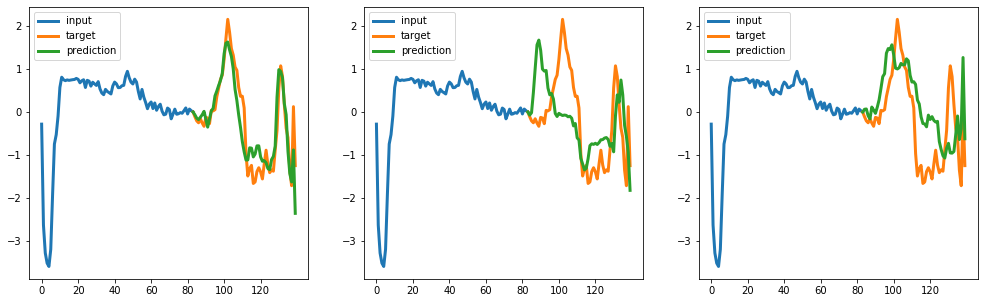

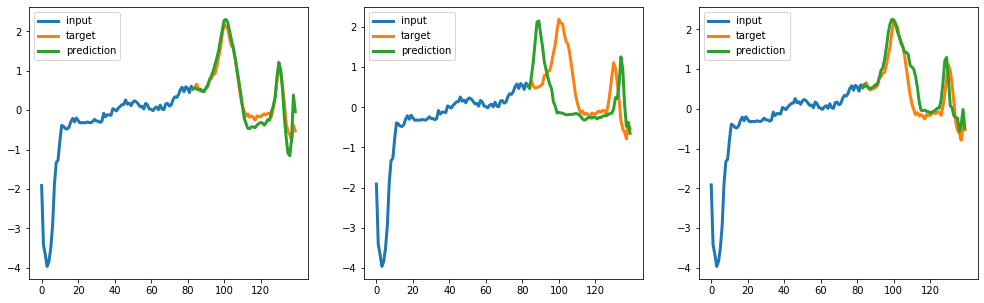

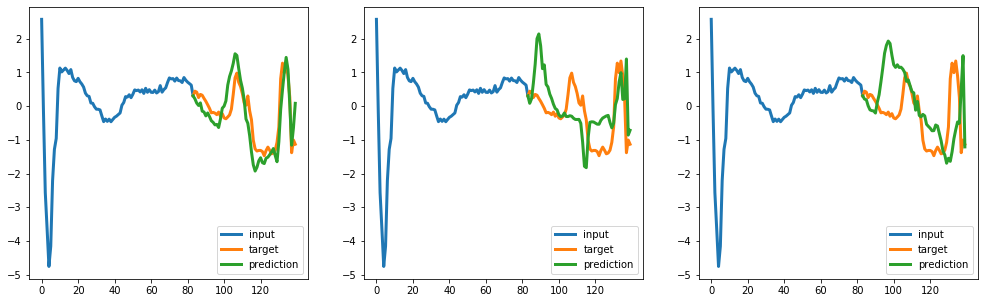

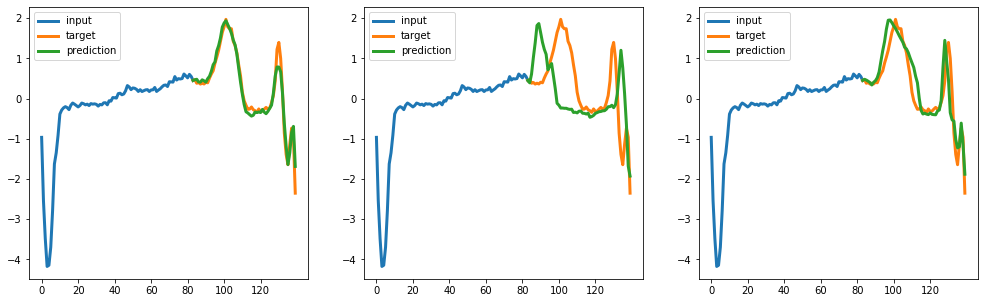

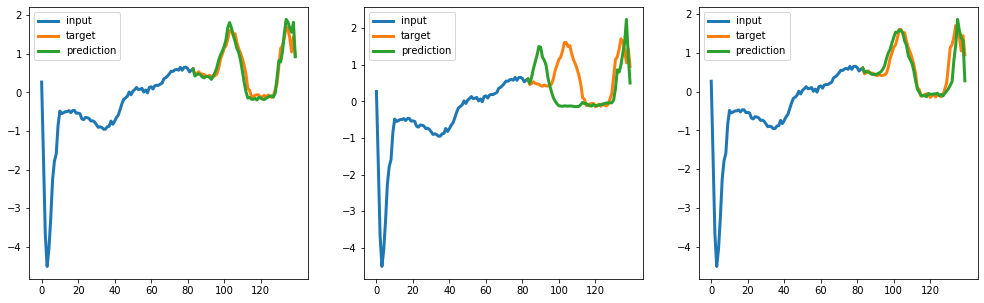

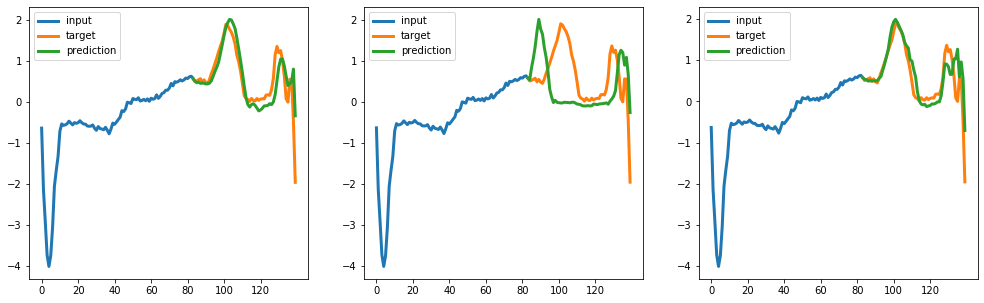

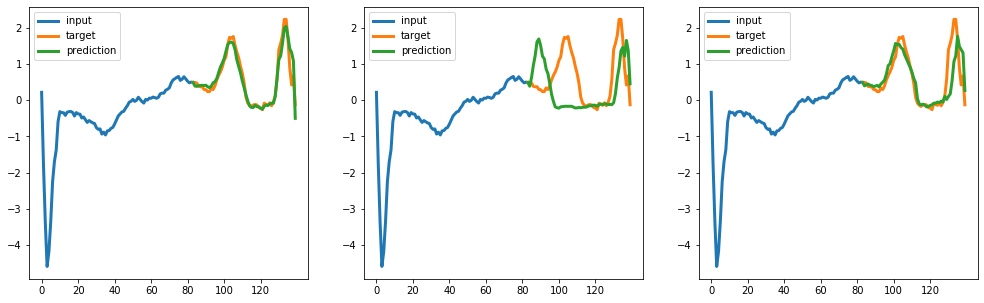

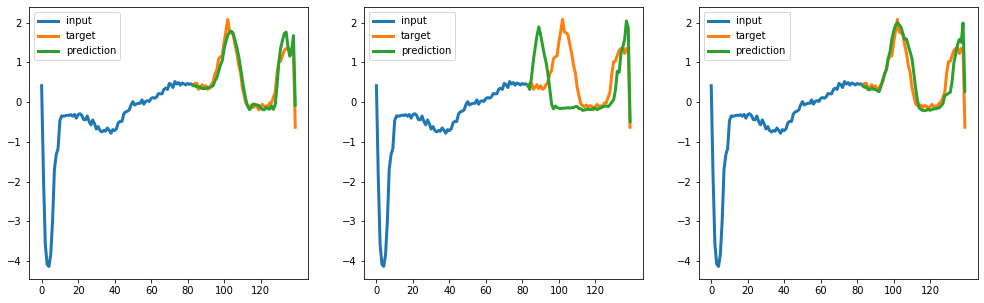

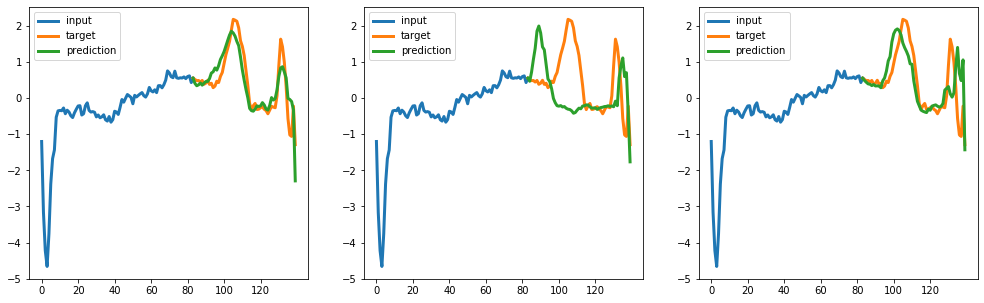

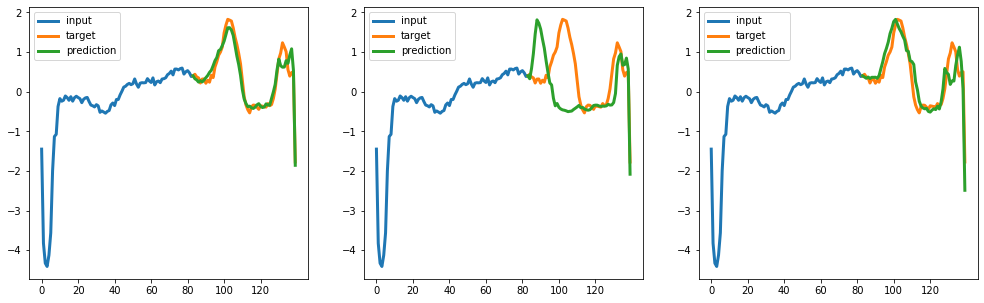

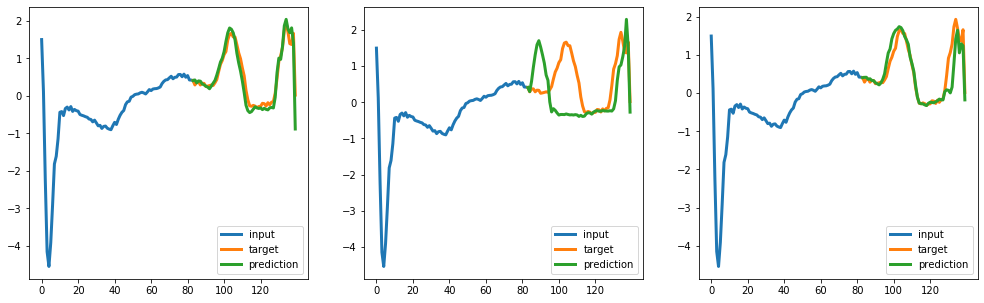

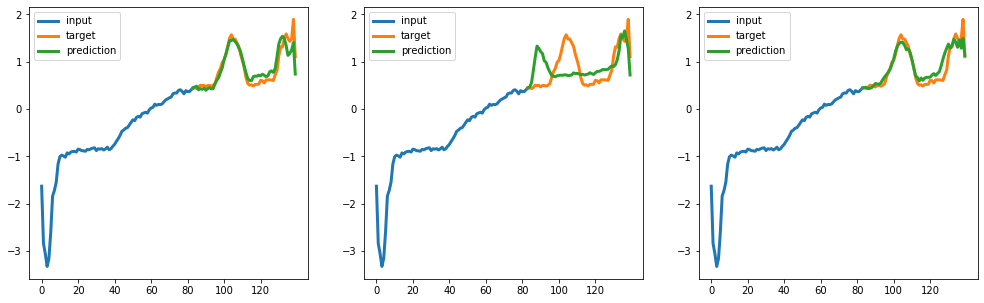

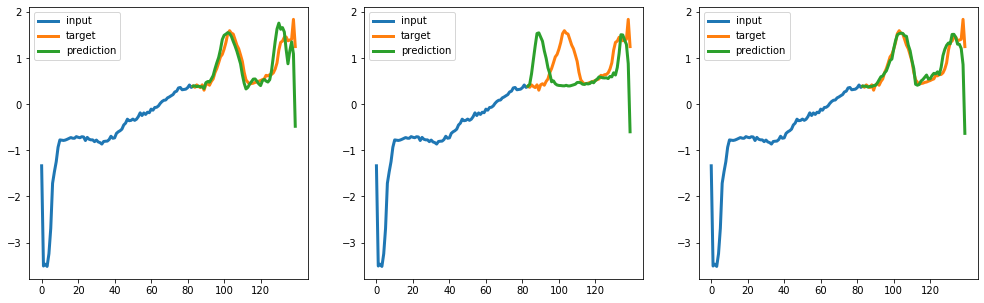

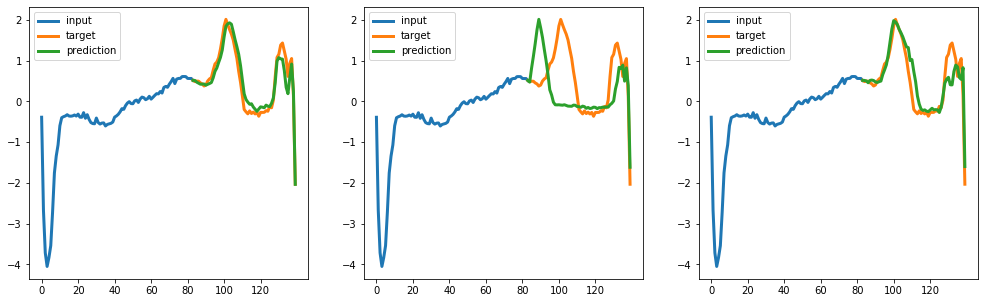

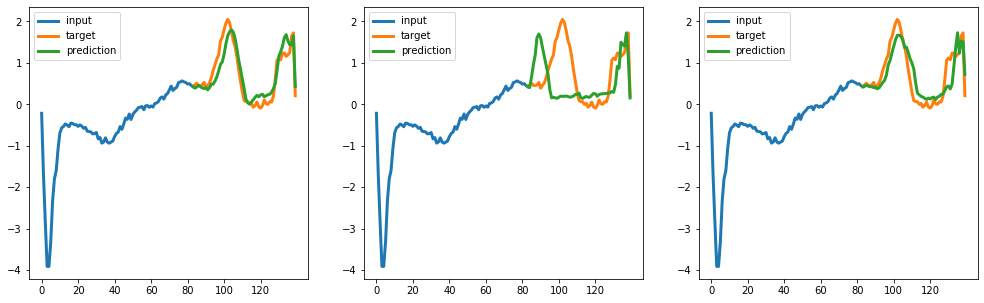

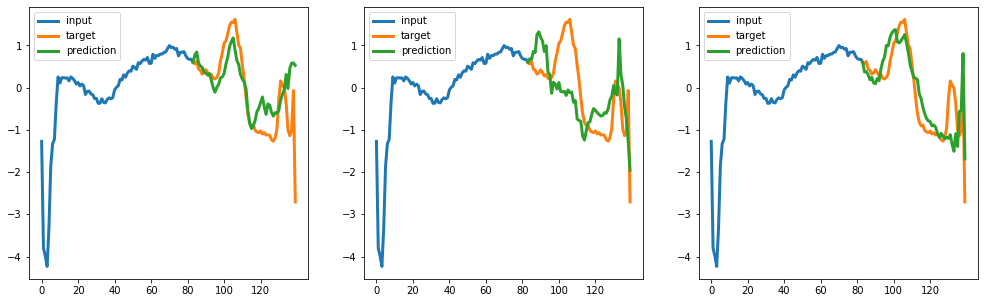

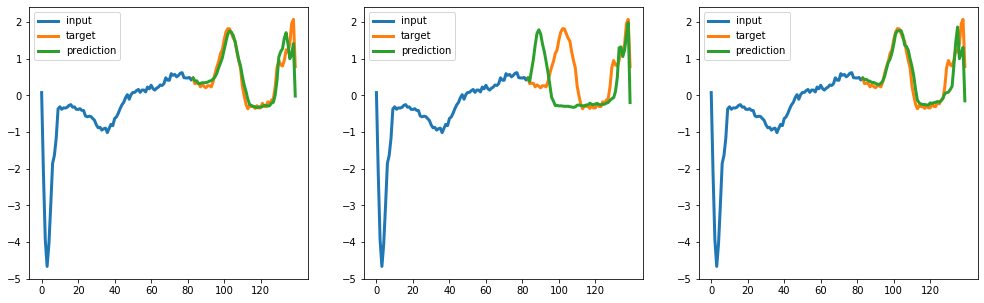

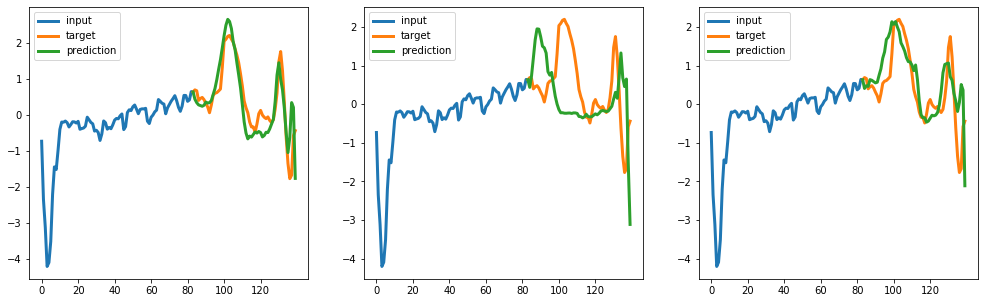

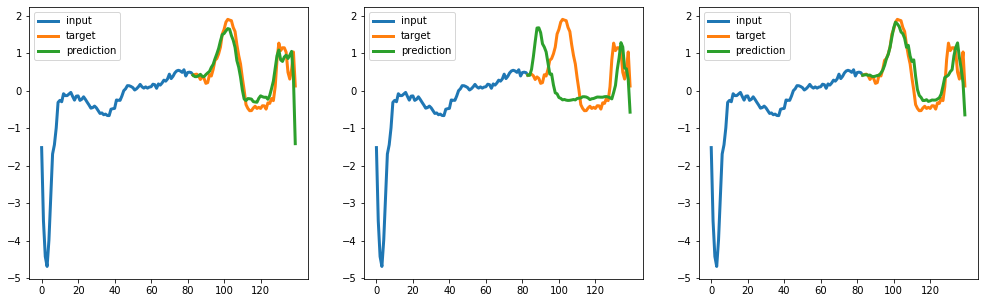

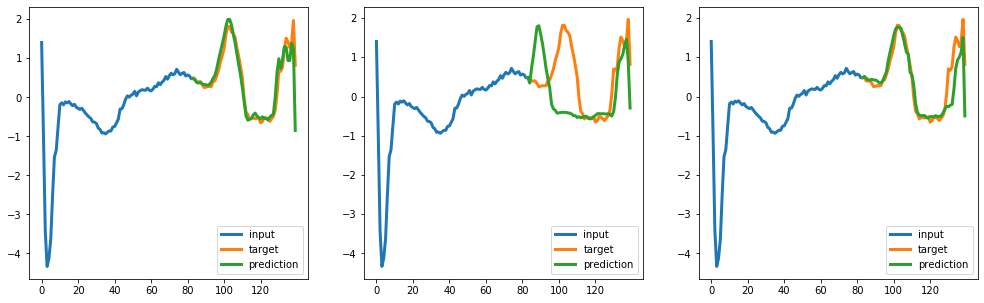

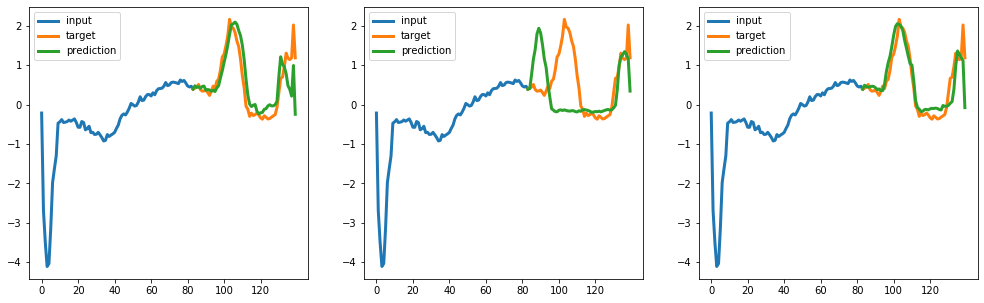

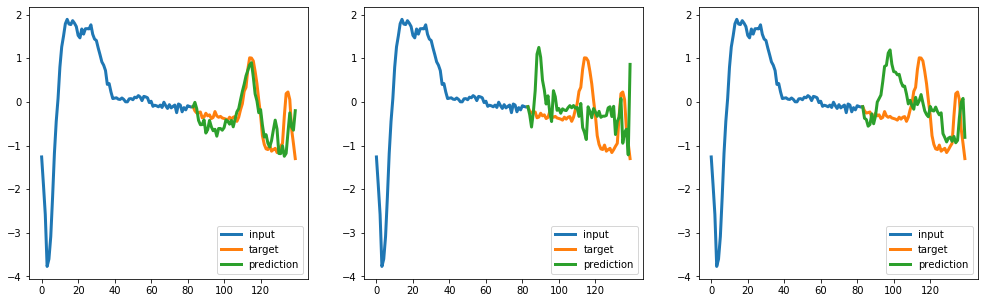

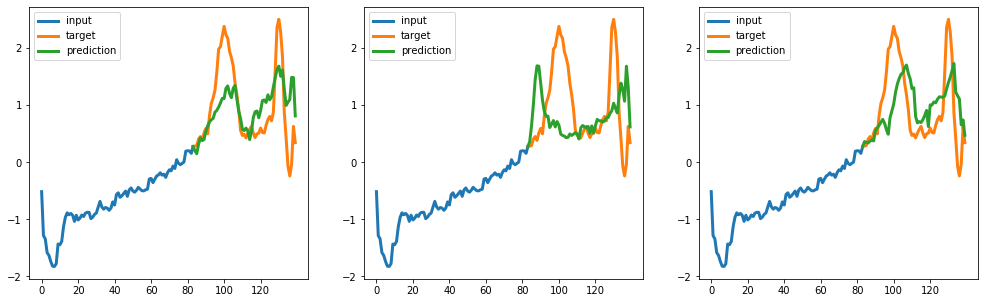

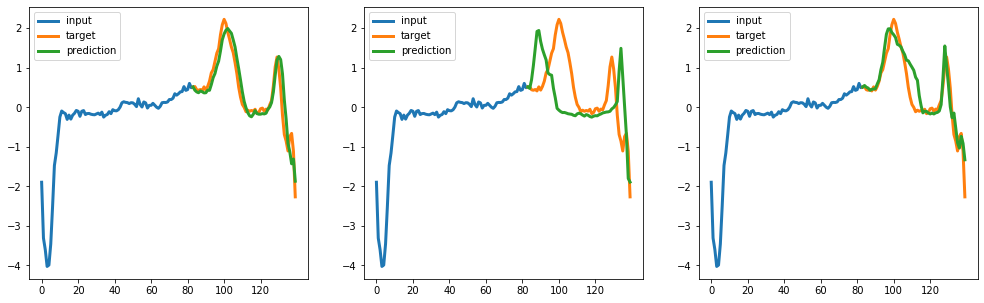

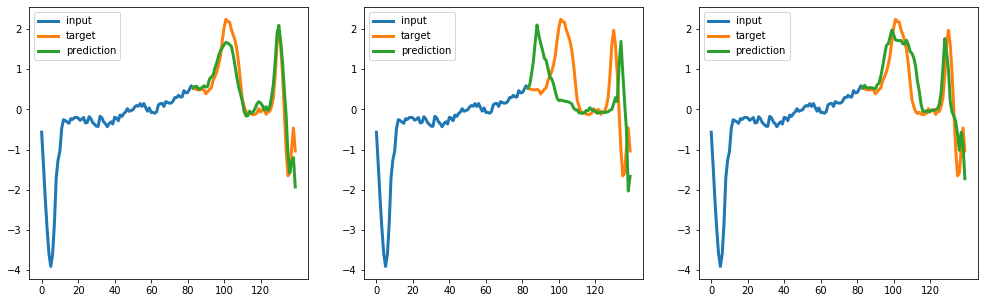

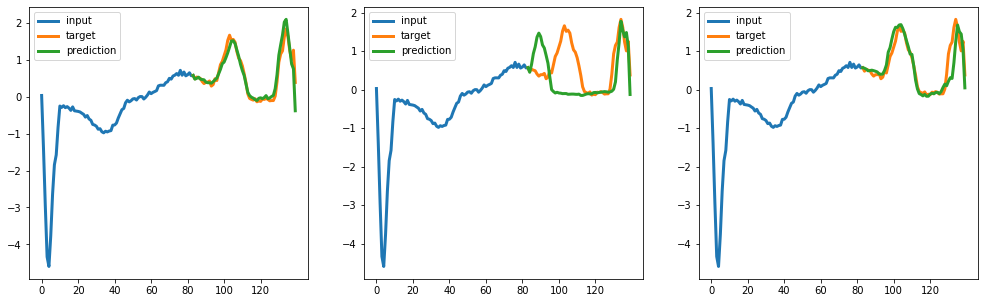

In [5]:

# Visualize results
gen_test = iter(testloader)
test_inputs, test_targets, breaks = next(gen_test)

test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device)
criterion = torch.nn.MSELoss()

nets = [net_cnn_lstm_mse,net_cnn_lstm_dialte_shape,net_cnn_lstm_dilate]

for ind in range(1,51):
    plt.figure()
    plt.rcParams['figure.figsize'] = (17.0,5.0)  
    k = 1
    for net in nets:
        pred = net(test_inputs).to(device)

        input = test_inputs.detach().cpu().numpy()[ind,:,:]
        target = test_targets.detach().cpu().numpy()[ind,:,:]
        preds = pred.detach().cpu().numpy()[ind,:,:]

        plt.subplot(1,3,k)
        plt.plot(range(0,N_input) ,input,label='input',linewidth=3)
        plt.plot(range(N_input-1,N_input+N_output), np.concatenate([ input[N_input-1:N_input], target ]) ,label='target',linewidth=3)   
        plt.plot(range(N_input-1,N_input+N_output),  np.concatenate([ input[N_input-1:N_input], preds ])  ,label='prediction',linewidth=3)       
        plt.xticks(range(0,N_input+N_output,20))
        plt.legend()
        k = k+1

    plt.show()